In [1]:
%matplotlib inline
from pathlib import Path
from cartopy import crs as ccrs
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import astropy.constants as astro
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import scipy as sc
import os
import sys
from windrose import WindroseAxes
import matplotlib.cm as cm
from scipy import integrate
import seaborn as sns
import datetime
from scipy.signal import argrelextrema

def savefig(filename, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
    else:
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
        
def save_netcdf(ds, name_file, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        ds.to_netcdf(directory_path + name_file, mode='w')
    else:
        ds.to_netcdf(directory_path + name_file, mode='w')
        
from box_coordinates_and_paths import choose_region

In [2]:
def derivatives(new_grid, unmasked_unvalid_input_data):
    vxyz = xr.concat([new_grid.cartesian_x_vertices, new_grid.cartesian_y_vertices, new_grid.cartesian_z_vertices], dim="xyz")
    cxyz = xr.concat([new_grid.cell_circumcenter_cartesian_x, new_grid.cell_circumcenter_cartesian_y, new_grid.cell_circumcenter_cartesian_z], dim="xyz")

    def norm(da, dim):
        axis = da.dims.index(dim)
        resulting_dims = tuple(d for d in da.dims if d != dim)
        return xr.DataArray(np.linalg.norm(da.values, axis=axis), dims=resulting_dims)

    def normalize(da, dim):
        return da / norm(da, dim)

    north      = xr.DataArray([0., 0., 1.], dims=("xyz",))
    cell_up    = cxyz
    cell_east  = normalize(xr.cross(north, cell_up, dim="xyz"), "xyz")
    cell_north = normalize(xr.cross(cell_up, cell_east, dim="xyz"), "xyz")

    local_orientation = xr.concat([cell_east, cell_north, cell_up], dim="enu")

    neighbors_mask  = (new_grid.neighbor_cell_index.T - 1)
    valid_mask      = np.all(neighbors_mask>=0, axis=-1)
    
    dxyz       = (cxyz.drop_vars("cell").isel(cell=neighbors_mask[valid_mask]) - cxyz[:,valid_mask]) * new_grid.attrs["sphere_radius"]
    denu       = xr.dot(local_orientation[:,:,valid_mask], dxyz, dims="xyz")

    de, dn, du = denu.transpose("enu", "cell", "nv").values
    ones       = np.ones_like(de)
    A          = np.stack((ones, de, dn), axis=-1)  # cells, neighbors, oll
    A_inv      = np.linalg.inv(A)
    
    print('A_inv.shape:', A_inv.shape)
    varibale_0, dvariable_dx, dvariable_dy = np.einsum('...ij,...j->i...', A_inv, unmasked_unvalid_input_data[...,neighbors_mask[valid_mask]])
    
    return varibale_0, dvariable_dx, dvariable_dy, valid_mask

def zonal_mean(variable, new_grid, bins):
    counts_per_bin, lat_bins = np.histogram(new_grid.clat, bins=bins)
    varsum_per_bin, _ = np.histogram(new_grid.clat, weights=variable, bins=bins)
    zonal_mean = varsum_per_bin / counts_per_bin
    return zonal_mean

def meridional_mean(variable, new_grid, bins):
    counts_per_bin, lon_bins = np.histogram(new_grid.clon, bins=bins)
    varsum_per_bin, _ = np.histogram(new_grid.clon, weights=variable, bins=bins)
    meridional_mean = varsum_per_bin / counts_per_bin
    return meridional_mean

In [3]:
OCEAN_TYPES = ['western_pacific'] #['atlantic', 'western_pacific']#, 'central_pacific', 'eastern_pacific', 'indian_ocean']
SEASONS = ['MAM'] #, 'JJA', 'SON', 'DJF']
YEARS = ['2020'] #, '2021', '2022']
TWO_YEAR_MEAN = 'non'

In [4]:
dpp        = 'ngc2009'
#year       = '2020'
#season     = "MAM"

In [5]:
import re

In [6]:
def increment_number_in_string(input_string):
    # Use regular expression to find the number in the string
    pattern = r'\d+'
    match = re.search(pattern, input_string)

    if match:
        # Extract the matched number
        number_str = match.group(0)
        # Convert it to an integer, increment by 1, and convert it back to a string
        incremented_number = str(int(number_str) + 1)

        # Replace the matched number with the incremented number in the original string
        result_string = re.sub(pattern, incremented_number, input_string, count=1)
        return result_string
    else:
        # If no number was found in the string, return the original string
        return input_string

In [7]:
import time

In [8]:
for ocean_type in OCEAN_TYPES:
    
    print(ocean_type)
    for year in YEARS:
        print(year)
        for season in SEASONS:
            start_time = time.time()  # Start time for the outer loop
            if season == 'DJF':
                year = increment_number_in_string(year)
            else:
                year = year            
            if season == 'MAM' and year == '2022':
                break
            print(season)

            season_counter_dict = {"counter": ['00', '01', '02', '03', '04', '05', '06', '07']}
            season_counter_df = pd.DataFrame(data=season_counter_dict, index=['2020_MAM', '2020_JJA', '2020_SON', '2021_DJF', '2021_MAM', '2021_JJA', '2021_SON', '2022_DJF'])
            counter  = season_counter_df.loc[f'{year}_{season}'].counter

            degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
            print("Fetching data for ", ocean_type, 'with:', choose_region(ocean_type))

            selected_indices     = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/selected_indices/selected_indices_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
            new_grid             = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
            selected_oce_indices = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/selected_indices/selected_oce_indices_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
            new_oce_grid         = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/new_grids/new_oce_grid_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc")
            vertical_grid        = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/vertical_info/vertical_info_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc", engine='netcdf4')

            if TWO_YEAR_MEAN == 'yes':
                filepath = f'/work/mh0731/m300868/00_DATA/ngc2009/09_wrapped_up_datasets/09_ngc2009_WRAPUP_dataset_region_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}_MAM_2020_to_DJF_2022_mean.nc'
                data = xr.open_dataset(filepath)
                print('Loaded TWO_YEAR_MEAN output')
            else:
                print(season)
                print(year)
                ## Seasonal Output
                filepath = f"/work/mh0731/m300868/00_DATA/{dpp}/09_wrapped_up_datasets/{year}/09_{dpp}_WRAPUP_dataset_region_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}_year_{year}_season_{season}.nc"                    
                data = xr.open_dataset(filepath)
                print('Loaded seasonal output')

            ### recovering the boolean in the valid and mask arrays
            data = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])

            valid     = data.valid.values
            valid_oce = data.valid_oce.values

            mask      = data.mask.values
            mask_oce  = data.mask_oce.values

            cell_height             = vertical_grid.cell_height[::-1,:][:,:][:,:]
            mean_cell_height        = cell_height.mean(axis=1)
            cell_height_valid_mask  = vertical_grid.cell_height[::-1,valid][:,mask][:,:]
            mean_cell_height_masked = cell_height_valid_mask.mean(axis=1)

            sfc_density_icon_orig = data.rho_3d.isel(height=0).rename({'all_cells':'cell'}).sel(cell=valid).sel(cell=mask)

            print("\nJust computed cell_height means, valid cells and mask cells!")

            g     = 9.787 # m/s at earth surface at the equator
            C_d   = 1.736e-3
            V_c   = 8

            H_0_height_limit = 21
            H_0_ds = xr.DataArray(cell_height[:H_0_height_limit,:].mean(axis=1).values, 
                                  coords={'H_0': cell_height[:H_0_height_limit,:].mean(axis=1).values}, 
                                  dims=["H_0"], 
                                  name="top_of_ABL")
            #H_0_ds

            ##### Wind

            zonal_wind_icon_orig      = data.uu.rename({'all_cells':'cell'}).sel(cell=valid).sel(cell=mask)
            meridional_wind_icon_orig = data.vv.rename({'all_cells':'cell'}).sel(cell=valid).sel(cell=mask)
            #zonal_wind_icon_orig

            ##### Vertical Info

            vertical_info_upside_down = xr.open_dataset(f"/work/mh0731/m300868/00_DATA/grid_info/vertical_info/vertical_info_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}.nc", engine='netcdf4')

            cell_thickness = -vertical_info_upside_down.cell_thickness[::-1,:][:21,:]
            #cell_thickness

            ##### Pressure

            pressure_field = data.pressure_fields.rename({'all_cells':'cell'})
            #pressure_field

            p0_icon_orig, dpdx_icon_orig, dpdy_icon_orig, valid_mask_mask = derivatives(new_grid, pressure_field)

            p0_icon_orig_int   = (p0_icon_orig   * cell_thickness.sel(cell=valid_mask_mask)).cumsum(dim='height')
            dpdx_icon_orig_int = (dpdx_icon_orig * cell_thickness.sel(cell=valid_mask_mask)).cumsum(dim='height')
            dpdy_icon_orig_int = (dpdy_icon_orig * cell_thickness.sel(cell=valid_mask_mask)).cumsum(dim='height')

            p0_int_icon_orig_ds   = xr.DataArray(p0_icon_orig, 
                                                dims=['height', 'cell'], 
                                                name="p0_icon_orig_ds")

            dpdx_int_icon_orig_ds = xr.DataArray(dpdx_icon_orig, 
                                                 dims=['height', 'cell'], 
                                                 name="dpdx_icon_orig_ds")

            dpdy_int_icon_orig_ds = xr.DataArray(dpdy_icon_orig, 
                                                 dims=['height', 'cell'], 
                                                 name="dpdy_icon_orig_ds")

            p0_icon_orig_int_ds   = xr.DataArray(p0_icon_orig_int, 
                                                dims=['height', 'cell'], 
                                                name="p0_icon_orig_int_ds")

            dpdx_icon_orig_int_ds = xr.DataArray(dpdx_icon_orig_int, 
                                                 dims=['height', 'cell'], 
                                                 name="dpdx_icon_orig_int_ds")

            dpdy_icon_orig_int_ds = xr.DataArray(dpdy_icon_orig_int, 
                                                 dims=['height', 'cell'], 
                                                 name="dpdy_icon_orig_int_ds")

            rho_dp_dx_prs_mom = (1/sfc_density_icon_orig) * dpdx_icon_orig_int_ds.sel(cell=mask)
            rho_dp_dy_prs_mom = (1/sfc_density_icon_orig) * dpdy_icon_orig_int_ds.sel(cell=mask)
            #rho_dp_dy_prs_mom

            ##### Coriolis

            def coriolis(reference_lat):   
                #siderial day in seconds: 86.164,0989 (source: Wikipedia)
                omega = 2 * np.pi / 86164.0989 #[1/s]
                return 2*omega*np.sin(np.deg2rad(reference_lat))

            f_coriolis = coriolis(np.rad2deg(new_grid.clat))
            #f_coriolis

            fu_cor_mom = f_coriolis.sel(cell=valid).sel(cell=mask) * zonal_wind_icon_orig
            fv_cor_mom = f_coriolis.sel(cell=valid).sel(cell=mask) * meridional_wind_icon_orig
            #fu_cor_mom

            ##### Tendency

            dudt_acc_mom = data.acceleration_u.rename({'valid_cells':'cell'}).sel(cell=mask)
            dvdt_acc_mom = data.acceleration_v.rename({'valid_cells':'cell'}).sel(cell=mask)
            #dudt_acc_mom

            ##### Advection - JPM60

            adv_data_directory = f'/work/mh0731/m300868/00_DATA/{dpp}/WIN23_ICON_output/Advection_JPM60/{ocean_type}/'
            adv_file_name = f'{counter}_{ocean_type}_ADVECTION_JPM60_duu_duv_dvv_{degrees_lower_box_bound}_{degrees_upper_box_bound}_{degrees_left_box_bound}_{degrees_right_box_bound}_{year}_{season}.nc'
            adv_JPM60 = xr.open_dataset(adv_data_directory + adv_file_name)

            uv_grad_u_adv_mom = adv_JPM60.integral_zonal_adv_duudx_duvdy.rename({'valid_cell':'cell'}).sel(cell=mask)
            uv_grad_v_adv_mom = adv_JPM60.integral_merid_adv_duvdx_dvvdy.rename({'valid_cell':'cell'}).sel(cell=mask)
            #uv_grad_u_adv_mom

            ##### Drag

            tau_u_dra_mom = data.surface_drag_u.rename({'all_cells':'cell'}).sel(cell=valid).sel(cell=mask)
            tau_v_dra_mom = data.surface_drag_v.rename({'all_cells':'cell'}).sel(cell=valid).sel(cell=mask)
            #tau_u_dra_mom

            ##### Turbulent Stress (positive upwards)

            u_turb_stress_mom = - dudt_acc_mom + fv_cor_mom - uv_grad_u_adv_mom - rho_dp_dx_prs_mom + tau_u_dra_mom
            v_turb_stress_mom = - dvdt_acc_mom - fu_cor_mom - uv_grad_v_adv_mom - rho_dp_dy_prs_mom + tau_v_dra_mom

            total_turb_stress_mom = u_turb_stress_mom + v_turb_stress_mom

            '''
            ds_merged_vertical_turb_fluxes = xr.Dataset({
                'u_turb_stress_mom': u_turb_stress_mom,
                'v_turb_stress_mom': v_turb_stress_mom,
                'total_turb_stress_mom': total_turb_stress_mom,
                'mean_cell_height': mean_cell_height.isel(height=slice(0,len(total_turb_stress_mom.height)))
            })
            
            filename = f'{year}_{season}_{ocean_type}_vert_fluxes.nc'
            filepath = f"/work/mh0731/m300868/00_DATA/Paper_Data_Revised/vert_turb_flux/{ocean_type}/"
            
            save_netcdf(ds_merged_vertical_turb_fluxes, filename, filepath)
            '''
            
            # End measuring time
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time taken for ocean type {ocean_type}: {elapsed_time:.2f} seconds")

western_pacific
2020
MAM
Fetching data for  western_pacific with: (-5, 5, 150, -160)
MAM
2020
Loaded seasonal output


/tmp/ipykernel_2101019/1282496009.py:42: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  data = xr.merge([xr.where(data['valid']==1, True, False), xr.where(data['valid_oce']==1, True, False), xr.where(data['mask']==1, True, False), xr.where(data['mask_oce']==1, True, False), data.drop({'valid', 'valid_oce', 'mask', 'mask_oce'})])



Just computed cell_height means, valid cells and mask cells!
A_inv.shape: (248692, 3, 3)
Time taken for ocean type western_pacific: 461.01 seconds


In [9]:
##### H0 Determination

#revised
datapath = "/work/mh0731/m300868/00_DATA/Paper_Data_Revised/"

seasons_df = pd.read_csv(datapath+'top_of_ABL_combined_review.csv', index_col=0)
print(seasons_df)

top_of_ABL = seasons_df.loc[f'{ocean_type}'][f'{year}-{season}']

print('!!! TOP OF ABL !!! = ', top_of_ABL, ', at ', mean_cell_height_masked[top_of_ABL].values)

                 2020-MAM  2020-JJA  2020-SON  2021-DJF  2021-MAM  2021-JJA   
western_pacific         8         8         8         7         8         8  \
central_pacific         8         8         8         8         8         8   
eastern_pacific        11        11        13        11        11        12   
indian_ocean            7         7         8         9         8         8   
atlantic                9        10        13        11         9         7   

                 2021-SON  2022-DJF  
western_pacific         8         7  
central_pacific         8         8  
eastern_pacific        12        11  
indian_ocean            7        12  
atlantic               14         9  
!!! TOP OF ABL !!! =  8 , at  906.39856


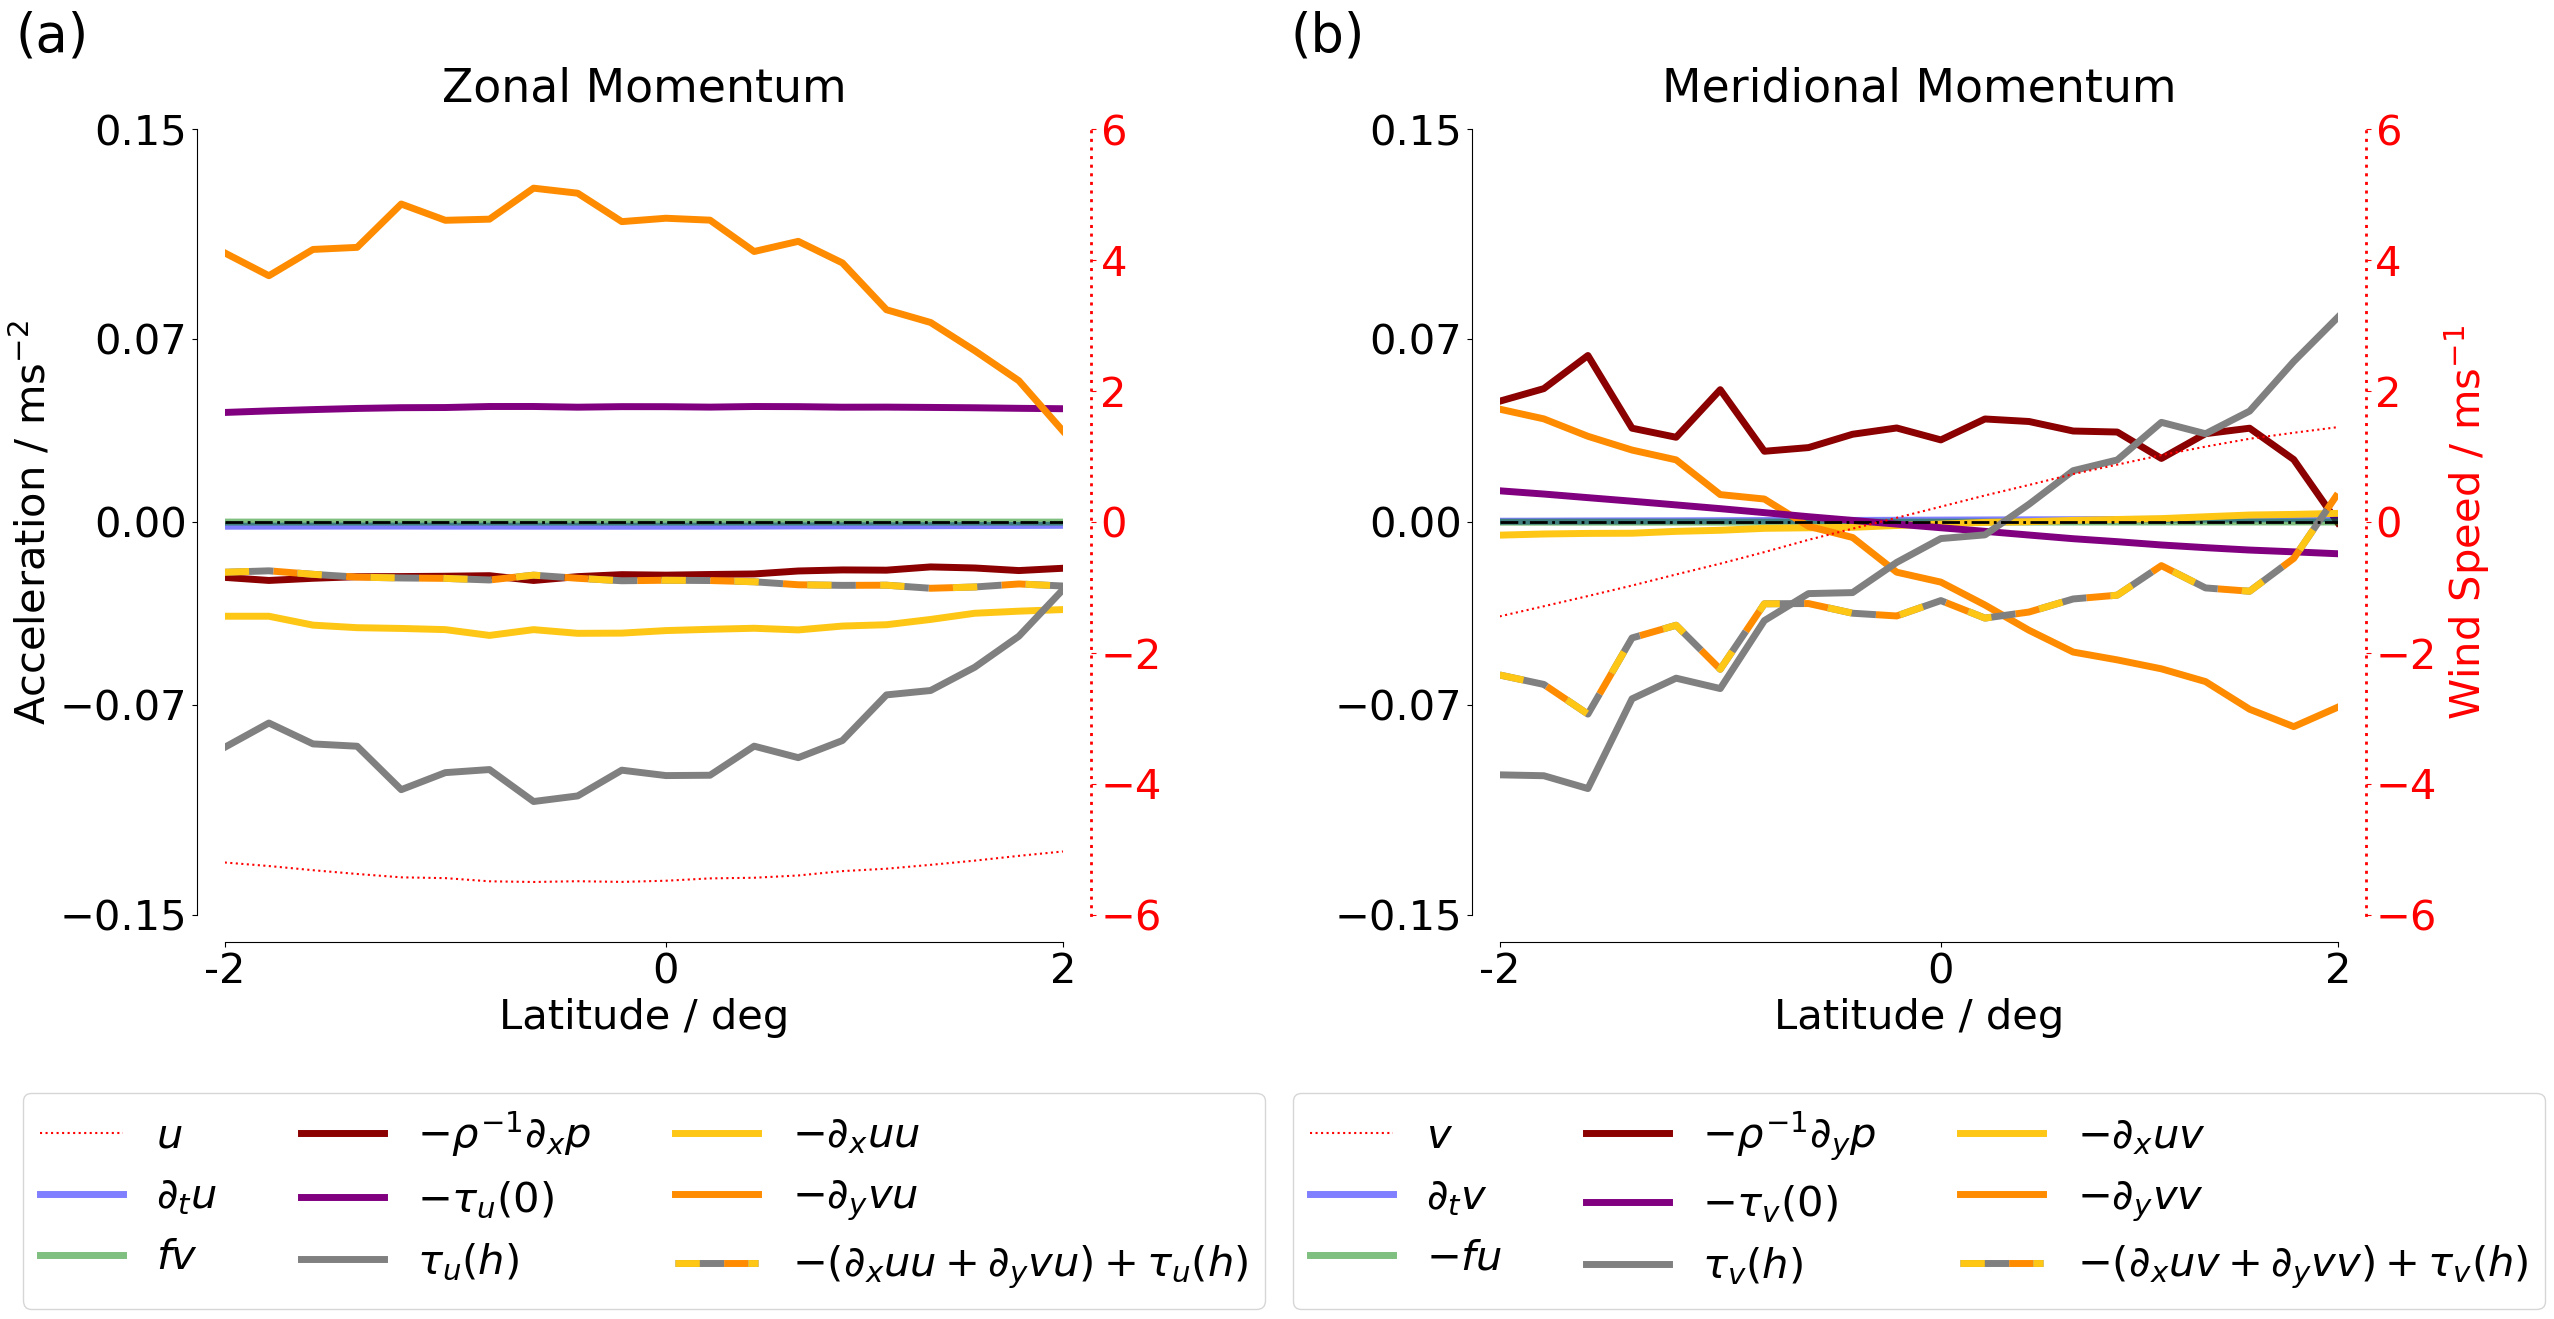

In [15]:
### Plotting

SIZE = 30
plt.rcParams['axes.labelsize']  = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE
plt.rcParams['font.size']       = SIZE

H0_lvl = top_of_ABL 

ZONAL_BINS = 20

########
########
# 2 to 2
########
########

two_to_two_mask = np.where((new_grid.sel(cell=valid).sel(cell=mask).clat < np.deg2rad(2)) & 
                           (new_grid.sel(cell=valid).sel(cell=mask).clat > np.deg2rad(-2)), 
                           True, False)

integral_duudx = adv_JPM60.integral_duudx.isel(height=H0_lvl).rename({'valid_cell':'cell'}).sel(cell=mask)
integral_duvdy = adv_JPM60.integral_duvdy.isel(height=H0_lvl).rename({'valid_cell':'cell'}).sel(cell=mask)
integral_dvudx = adv_JPM60.integral_dvudx.isel(height=H0_lvl).rename({'valid_cell':'cell'}).sel(cell=mask)
integral_dvvdy = adv_JPM60.integral_dvvdy.isel(height=H0_lvl).rename({'valid_cell':'cell'}).sel(cell=mask)

fig = plt.figure(figsize=(26,15), facecolor='w', edgecolor='k')
#fig.suptitle(f"Momentum Balance within Boundary Layer of "+f'H$_0$ = {mean_cell_height[top_of_ABL].values:.2f}m depth.', y=1, fontsize=SIZE)

G = gridspec.GridSpec(1,2)

ax1  = plt.subplot(G[0,0])
ax11 = ax1.twinx()


tend, = ax1.plot(zonal_mean(-dudt_acc_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), alpha=0.5, lw=5, color="blue", label='Tendency')
cori, = ax1.plot(zonal_mean(fv_cor_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), alpha=0.5, lw=5, color="green", label='Coriolis Force')
prs,  = ax1.plot(zonal_mean(-rho_dp_dx_prs_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="darkred", label='Pressure Gradient Force')
sfcdrag, = ax1.plot(zonal_mean(tau_u_dra_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="purple", label='Surface Drag')
#ax1.plot(zonal_mean(-uv_grad_u_adv_mom.isel(height=H0_lvl), new_grid.sel(cell=valid).sel(cell=mask), ZONAL_BINS),  lw=5, color="orange", label='Advection Force')
dxuu, = ax1.plot(zonal_mean(-integral_duudx.sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="#fec615", label='Advection Force')
dyuv, = ax1.plot(zonal_mean(-integral_duvdy.sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="#ff8c00", label='Advection Force')

turbfl, = ax1.plot(zonal_mean(-u_turb_stress_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="grey", label='Vertical Turbulent Flux')

zebra_line = (-u_turb_stress_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask)) + (-uv_grad_u_adv_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask))
#ax1.plot(zonal_mean(zebra_line, new_grid.sel(cell=valid).sel(cell=mask), ZONAL_BINS), dashes=[5, 5], lw=5, color="grey", gapcolor="orange", label='Advection Force +\nVertical Turbulent Flux')

part1, = ax1.plot(zonal_mean(zebra_line, new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), dashes=[7, 3.5], lw=5, color="grey", gapcolor="#ff8c00", label=r'$-(\partial_x uu + \partial_y vu) + \tau_h$')
part2, = ax1.plot(zonal_mean(zebra_line, new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), dashes=[3.5, 7], lw=5, color="#fec615")


ax1.axhline(y = 0, color = 'black', linestyle = '-.', lw=2, zorder=10)

ax1.set_title('Zonal Momentum', fontsize=SIZE+3, pad=20)
ax1.set_xlabel('Latitude / deg', fontsize=SIZE)
ax1.set_ylabel(r'Acceleration / $\mathrm{ms}^{-2}$', fontsize=SIZE, color='black')
ax1.set_xlim(0, ZONAL_BINS-1)
ax1.set_xticks([0, ZONAL_BINS/2, ZONAL_BINS-1])
ax1.set_xticklabels(['-2', '0', '2'])
#ax1.axvline((ZONAL_BINS/2)-(0.2*ZONAL_BINS), zorder=1, lw=0.5, color='grey')
#ax1.axvline((ZONAL_BINS/2)+(0.2*ZONAL_BINS), zorder=1, lw=0.5, color='grey')
#ax1.axvspan((ZONAL_BINS/2)-(0.2*ZONAL_BINS), (ZONAL_BINS/2)+(0.2*ZONAL_BINS), color='grey', alpha=0.1)
ax1.spines[['left', 'right', 'bottom']].set_position(('outward',20))
ax1.spines[['right', 'top']].set_visible(False)
#ax1.spines[['left']].set_visible(False)
#ax1.spines['left'].set_color('white') 
#ax1.tick_params(axis='y', labelcolor='white', color='white')
#ax1.yaxis.label.set_color('white')

uwind, = ax11.plot(zonal_mean(zonal_wind_icon_orig.isel(height=0).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), color="red", label=r'Reference Wind', ls='dotted', zorder=0)

ax11.set_ylim(-6,6)
ax11.spines[['right']].set_visible(True)
ax11.spines[['left', 'bottom', 'top']].set_visible(False)
ax11.spines[['right']].set_position(('outward',20))
ax11.spines['right'].set_linestyle((0,(0.1,3)))
ax11.spines['right'].set_linewidth(2)
ax11.spines['right'].set_color('red')
ax11.yaxis.label.set_color('red')
ax11.tick_params(axis='y', colors='red')


ax1.legend([uwind, tend, cori, prs, sfcdrag, turbfl, dxuu, dyuv, (part1, part2)], [r'$u$', r'$\partial_t u$', r'$fv$', r'$-\rho^{-1} \partial_x p$', r'$-\tau_u(0)$', r'$\tau_u(h)$', r'$-\partial_x uu$', r'$-\partial_y vu$', r'$-(\partial_x uu + \partial_y vu) + \tau_u(h)$'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=3)

##################################################################
##################################################################

ax2  = plt.subplot(G[0,1])
ax22 = ax2.twinx()

prs, = ax2.plot(zonal_mean(-rho_dp_dy_prs_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="darkred", label='prs')
tend, = ax2.plot(zonal_mean(-dvdt_acc_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), alpha=0.5, lw=5, color="blue", label='acc')
cori, = ax2.plot(zonal_mean(-fu_cor_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), alpha=0.5, lw=5, color="green", label='cor')
#ax2.plot(zonal_mean(-uv_grad_v_adv_mom.isel(height=H0_lvl), new_grid.sel(cell=valid).sel(cell=mask), ZONAL_BINS),  lw=5, color="orange", label='adv')
dxvu, = ax2.plot(zonal_mean(-integral_dvudx.sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="#fec615", label='adv')
dyvv, = ax2.plot(zonal_mean(-integral_dvvdy.sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="#ff8c00", label='adv')

sfcdrag, = ax2.plot(zonal_mean(tau_v_dra_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="purple", label='dra')
turbfl, = ax2.plot(zonal_mean(-v_turb_stress_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS),  lw=5, color="grey", label='turb flux')

zebra_line = (-v_turb_stress_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask)) + (-uv_grad_v_adv_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask))
#ax2.plot(zonal_mean(zebra_line, new_grid.sel(cell=valid).sel(cell=mask), ZONAL_BINS), dashes=[5, 5], lw=5, color="grey", gapcolor="orange", label='adv+tflx')

part1, = ax2.plot(zonal_mean(zebra_line, new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), dashes=[7, 3.5], lw=5, color="grey", gapcolor="#ff8c00", label=r'$-(\partial_x uu + \partial_y vu) + \tau_h$')
part2, = ax2.plot(zonal_mean(zebra_line, new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), dashes=[3.5, 7], lw=5, color="#fec615")


ax2.axhline(y = 0, color = 'black', linestyle = '-.', lw=2, zorder=10)

ax2.set_title('Meridional Momentum', fontsize=SIZE+3, pad=20)
ax2.set_xlabel('Latitude / deg', fontsize=SIZE)
#ax2.set_ylabel(r'Acceleration / $\frac{m}{s^2}$')
ax2.set_xlim(0, ZONAL_BINS-1)
ax2.set_xticks([0, ZONAL_BINS/2, ZONAL_BINS-1])
ax2.set_xticklabels(['-2', '0', '2'])
#ax2.axvline((ZONAL_BINS/2)-(0.2*ZONAL_BINS), zorder=1, lw=0.5, color='grey')
#ax2.axvline((ZONAL_BINS/2)+(0.2*ZONAL_BINS), zorder=1, lw=0.5, color='grey')
#ax2.axvspan((ZONAL_BINS/2)-(0.2*ZONAL_BINS), (ZONAL_BINS/2)+(0.2*ZONAL_BINS), color='grey', alpha=0.1)
ax2.spines[['left', 'right', 'bottom']].set_position(('outward',20))
ax2.spines[['right', 'top']].set_visible(False)

vwind, = ax22.plot(zonal_mean(meridional_wind_icon_orig.isel(height=0).sel(cell=two_to_two_mask), new_grid.sel(cell=valid).sel(cell=mask).sel(cell=two_to_two_mask), ZONAL_BINS), color="red", label=r'$\frac{1}{50}$ wind', ls='dotted')
ax22.set_ylim(-6,6)
ax22.spines[['right']].set_visible(True)
ax22.spines[['left', 'bottom', 'top']].set_visible(False)
ax22.spines[['right']].set_position(('outward',20))
ax22.spines['right'].set_linestyle((0,(0.1,3)))
ax22.spines['right'].set_linewidth(2)
ax22.spines['right'].set_color('red')
ax22.yaxis.label.set_color('red')
ax22.tick_params(axis='y', colors='red')
ax22.set_ylabel(r'Wind Speed / $\mathrm{ms}^{-1}$', fontsize=SIZE)#, rotation=-90)

#ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=False, ncol=4)
ax2.legend([vwind, tend, cori, prs, sfcdrag, turbfl, dxvu, dyvv, (part1, part2)], [r'$v$', r'$\partial_t v$', r'$-fu$', r'$-\rho^{-1} \partial_y p$', r'$-\tau_v(0)$', r'$\tau_v(h)$', r'$- \partial_x uv$', r'$- \partial_y vv$', r'$-(\partial_x uv + \partial_y vv) + \tau_v(h)$'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=False, ncol=3)

if ocean_type == 'western_pacific':
    ax1.set_ylim(-0.15,0.15)
    ax1.set_yticks([-0.15, -0.07, 0, 0.07, 0.15])
    ax2.set_ylim(-0.15,0.15)
    ax2.set_yticks([-0.15, -0.07, 0, 0.07, 0.15])
elif ocean_type == 'atlantic':
    ax1.set_ylim(-2,2)
    ax1.set_yticks([-2, -1, 0, 1, 2])
    ax2.set_ylim(-2,2)
    ax2.set_yticks([-2, -1, 0, 1, 2])

ax1.text(-0.25, 1.1, '(a)', fontsize=SIZE+8, transform=ax1.transAxes)
ax2.text(-0.25, 1.1, '(b)', fontsize=SIZE+8, transform=ax2.transAxes)

plt.tight_layout()

filename = f'fig_04_revised.pdf'
filepath = 'figs_review/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=400)

plt.show()

In [11]:
# Psi Calculation

### 2 to 2 mask


zebra_u_line = ((-u_turb_stress_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask)) + (-uv_grad_u_adv_mom.isel(height=H0_lvl)).sel(cell=two_to_two_mask)).mean()

zebra_v_line = ((-v_turb_stress_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask)) + (-uv_grad_v_adv_mom.isel(height=H0_lvl)).sel(cell=two_to_two_mask)).mean()

prs_u = (-rho_dp_dx_prs_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask)).mean()

prs_v = (-rho_dp_dy_prs_mom.isel(height=H0_lvl).sel(cell=two_to_two_mask)).mean()

psi_u = (zebra_u_line / prs_u)

psi_v = (zebra_v_line / prs_v)

print(r"2x2: psi_u = ", psi_u.values)
print(r"2x2: psi_v = ", psi_v.values)

### 5 to 5 mask

zebra_u_line = ((-u_turb_stress_mom.isel(height=H0_lvl)) + (-uv_grad_u_adv_mom.isel(height=H0_lvl))).mean()

zebra_v_line = ((-v_turb_stress_mom.isel(height=H0_lvl)) + (-uv_grad_v_adv_mom.isel(height=H0_lvl))).mean()

prs_u = (-rho_dp_dx_prs_mom.isel(height=H0_lvl)).mean()

prs_v = (-rho_dp_dy_prs_mom.isel(height=H0_lvl)).mean()

psi_u = (zebra_u_line / prs_u)

psi_v = (zebra_v_line / prs_v)

print(r"5x5: psi_u = ", psi_u.values)
print(r"5x5: psi_v = ", psi_v.values)

2x2: psi_u =  1.1221969100412055
2x2: psi_v =  -0.9937511432561996
5x5: psi_u =  0.6318699825362087
5x5: psi_v =  1.4488065411197408
